In [43]:
from pymoo.problems.many.dtlz import DTLZ2
from pymoo.util.ref_dirs import get_reference_directions
import pandas as pd
from pymoo.util.dominator import Dominator
from pymoo.indicators.hv import Hypervolume
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from pymoo.operators.sampling.lhs import LHS
import matplotlib.pyplot as plt
from pymoo.indicators.hv import HV
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.display.output import Output, pareto_front_if_possible
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np
import random

#### Number of Bojectives = 2 , Number of decision variables = 2 , Number of samples = 20(10 x 2)

In [39]:
weight_vectors = get_reference_directions('energy',2,20)

In [3]:
problem = DTLZ2(n_obj=2,n_var=2)
sampling  = LHS()
ref_dirs = sampling(problem,20).get('X')

In [4]:
ref_dirs

array([[0.0916874 , 0.61203144],
       [0.01731574, 0.34846604],
       [0.17866975, 0.41672974],
       [0.23170817, 0.13624386],
       [0.77570343, 0.95583783],
       [0.96734247, 0.18031023],
       [0.60281924, 0.37989949],
       [0.84654968, 0.281281  ],
       [0.42285467, 0.74045622],
       [0.13649143, 0.06850451],
       [0.48370422, 0.53633135],
       [0.70872952, 0.8487783 ],
       [0.33217658, 0.47130666],
       [0.35398158, 0.20735533],
       [0.66170283, 0.55998051],
       [0.59102917, 0.04311915],
       [0.29005134, 0.78429923],
       [0.92050745, 0.93355153],
       [0.51001   , 0.88331482],
       [0.85717271, 0.68634259]])

In [5]:
output = {}
problem._evaluate(ref_dirs,output)

In [6]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,3):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2']


In [7]:
dataset.head()

,x1,x2,Objective 1,Objective 2
0,0.091687,0.612031,1.002068,0.145326
1,0.017316,0.348466,1.022584,0.027821
2,0.178670,0.416730,0.967537,0.278905
3,0.231708,0.136244,1.058143,0.403087
4,0.775703,0.955838,0.416784,1.133598


##### MOdelling on Objective 1

In [8]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [9]:
kernel_2 = C(1.0) * RBF(length_scale=0.1) 
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=40,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


#### Model on Objective 2

In [10]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) 
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=12).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [17]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [18]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [14]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm,
                ('n_gen', 50),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm,
                ('n_gen', 50),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [25]:
# non dominated sorting

def fast_non_dominated_sort(F, **kwargs):
    
    M = Dominator.calc_domination_matrix(F)

    # calculate the dominance matrix
    n = M.shape[0]

    fronts = []

    if n == 0:
        return fronts

    # final rank that will be returned
    n_ranked = 0
    ranked = np.zeros(n, dtype=int)

    # for each individual a list of all individuals that are dominated by this one
    is_dominating = [[] for _ in range(n)]

    # storage for the number of solutions dominated this one
    n_dominated = np.zeros(n)

    current_front = []

    for i in range(n):

        for j in range(i + 1, n):
            rel = M[i, j]
            if rel == 1:
                is_dominating[i].append(j)
                n_dominated[j] += 1
            elif rel == -1:
                is_dominating[j].append(i)
                n_dominated[i] += 1

        if n_dominated[i] == 0:
            current_front.append(i)
            ranked[i] = 1.0
            n_ranked += 1

    # append the first front to the current front
    fronts.append(current_front)

    # while not all solutions are assigned to a pareto front
    while n_ranked < n:

        next_front = []

        # for each individual in the current front
        for i in current_front:

            # all solutions that are dominated by this individuals
            for j in is_dominating[i]:
                n_dominated[j] -= 1
                if n_dominated[j] == 0:
                    next_front.append(j)
                    ranked[j] = 1.0
                    n_ranked += 1

        fronts.append(next_front)
        current_front = next_front

    return fronts

In [35]:
def optimize_problem(algorithm, problem_1,problem_2):
    data = []
    Hypervolume  = []
    for i in range(50):
        data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm))
        new_data = list(ref_dirs) + data
        new_data = np.array(new_data)
        output = {}
        new_objectives  = problem._evaluate(new_data,output)
        new_dataset = pd.DataFrame(data = new_data,columns = columns)
        new_obj1 = [i[0] for i in output['F']]
        new_obj2 = [i[1] for i in output['F']]
        new_dataset['Objective 1']  = new_obj1
        new_dataset['Objective 2'] = new_obj2
        objectives_new = []
        objectives1_new = list(new_dataset['Objective 1'])
        objectives2_new = list(new_dataset['Objective 2'])
        for j in range(len(new_dataset['Objective 1'])):
            objectives_new.append([objectives1_new[j],objectives2_new[j]])
        #print('Calculating Front')
        fronts_new = fast_non_dominated_sort(np.array(objectives_new))
        ref_vector  = [max(objectives1_new),max(objectives2_new)]
        objectives  = np.array(objectives_new)
        #print('Calculating Hypervolumne',objectives[fronts_new[0]])
        ind = HV(ref_point=ref_vector)
        Hypervolume.append(ind(objectives[fronts_new[0]]))
        print('Iteration : {0} Hypervolume of Non Dominated Front is {1}'.format(i,ind(objectives[fronts_new[0]])))
    plt.plot(list(range(1,51)),Hypervolume)
    plt.title('Hypervolume Increase in 50 Generations')
    plt.show()


In [44]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm = NSGA2(pop_size = 100)
algorithm_2 = MOEAD(ref_dirs=weight_vectors)
algorithm_3 = NSGA3(ref_dirs=weight_vectors)


Iteration : 0 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 1 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 2 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 3 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 4 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 5 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 6 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 7 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 8 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 9 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 10 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 11 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 12 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 13 Hypervolume of Non Dominated Front is 0.482437

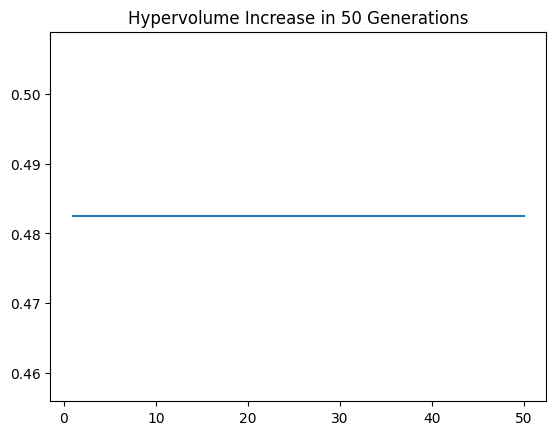

In [36]:
optimize_problem(algorithm,problem_1,problem_2)


Iteration : 0 Hypervolume of Non Dominated Front is 0.48340860462600765
Iteration : 1 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 2 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 3 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 4 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 5 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 6 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 7 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 8 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 9 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 10 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 11 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 12 Hypervolume of Non Dominated Front is 0.48773477715110747
Iteration : 13 Hypervolume of Non Dominated Front is 0.487734

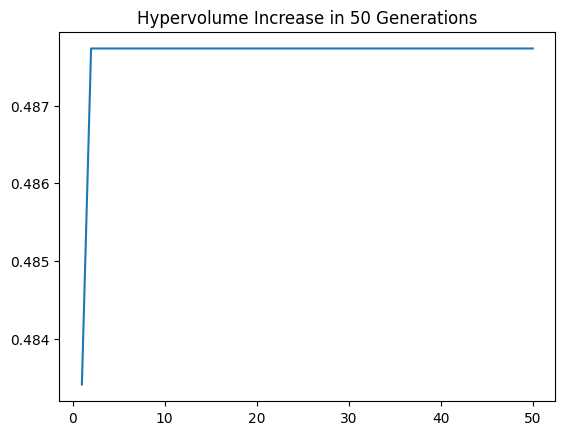

In [42]:
optimize_problem(algorithm_2,problem_1,problem_2)


Iteration : 0 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 1 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 2 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 3 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 4 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 5 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 6 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 7 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 8 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 9 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 10 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 11 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 12 Hypervolume of Non Dominated Front is 0.48243748715999735
Iteration : 13 Hypervolume of Non Dominated Front is 0.482437

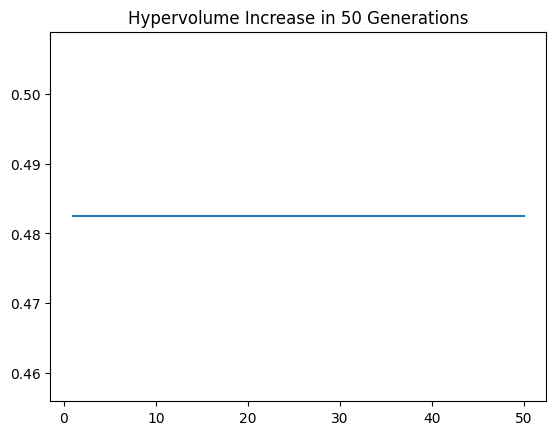

In [45]:
optimize_problem(algorithm_3,problem_1,problem_2)